In [1]:
#import libraries
import ximea 
from ximea import xiapi
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time
import cv2
import PIL
from PIL import Image as im
import napari
import moviepy.editor as mp

In [2]:
#Create camera object
cam1 = xiapi.Camera();
cam2 = xiapi.Camera();
#Create image object
img1 = xiapi.Image()
img2 = xiapi.Image()
#Open device using the serial number obtained from ximeaCOP
cam1.open_device_by_SN('CAMAU2146005');
cam2.open_device_by_SN('CAMAU2146022');

In [3]:
#Start acquisition
cam1.start_acquisition()
cam2.start_acquisition()

In [4]:
#SETTINGS
#Allows access to sensor feature value currently 
#selected by XI_PRM_SENSOR_FEATURE_SELECTOR
cam1.set_sensor_feature_value(1)
cam2.set_sensor_feature_value(1)
#Define exposure 
cam1.set_exposure(int(5000))
cam2.set_exposure(int(5000))
#Define framerate 
cam1.set_framerate(100)
cam2.set_framerate(100)
fps = int(cam1.get_framerate())
fps

# FourCC is a 4-byte code used to specify the video codec.
fourcc = cv2.VideoWriter_fourcc(*'MP42')

In [35]:
#FOCUS AND ILLUMINATION CALIBRATION

try:
    print('Starting calibration...')
    #read current time
    t0 = time.time()
    while True:
        #get images
        cam1.get_image(img1)
        cam2.get_image(img2)
        
        
        
        #create numpy array for each camera
        data1 = img1.get_image_data_numpy()
        data2 = img2.get_image_data_numpy()

        
        
        #concatenates arrays
        concat_data_cal = np.concatenate((data1, data2), axis=1)

        #show video with a timer
        font = cv2.FONT_HERSHEY_PLAIN
        text = '{:5.2f}'.format((time.time()-t0))
        cv2.putText(concat_data_cal, text, (1850,50), font, 4, (255, 255, 255), 2)
        video_cal = cv2.resize(concat_data_cal, (1936, 608))
        cv2.imshow('VIDEO CALIBRATION', video_cal)
        
        #waits for a key event for a "delay" of 1ms
        cv2.waitKey(1)
                
#halt acquisition
except KeyboardInterrupt:
        cv2.destroyAllWindows()
        cv2.waitKey(0)

Starting calibration...


In [183]:
#VIDEO ACQUISITION
video_array1 = []
video_array2 = []
seconds = 30
timing =time.time() + seconds
try:
    t0 = time.time()
    print('Starting video recording...')
    while time.time() < timing:
        #get images
        cam1.get_image(img1)
        cam2.get_image(img2)
        
        #create numpy array for each camera
        data_raw1 = img1.get_image_data_numpy()
        
        data_raw2 = img2.get_image_data_numpy()
        
        concat_data = np.concatenate((data_raw1, data_raw2), axis=1)
        video_rez = cv2.resize(concat_data, (1936, 608))
        font = cv2.FONT_HERSHEY_PLAIN
        text = '{:5.2f}'.format((time.time()-t0))
        cv2.putText(video_rez, text, (1700,50), font, 4, (255, 255, 255), 2)



        cv2.imshow('VIDEO CAMERA 2', video_rez)
        video_array1.append(data_raw1)
        video_array2.append(data_raw2)

        #waits for a key event for a "delay" of 1ms
        cv2.waitKey(1)

        
#halt acquisition
except KeyboardInterrupt:
    cv2.destroyAllWindows()

Starting video recording...


In [36]:
#Get image from CAMERA2 as a numpy array
cam2.get_image(img2)
data_raw2 = img2.get_image_data_numpy()
viewer2=napari.Viewer()
viewer2.add_image(data_raw2)

#Get image from CAMERA2 as a numpy array
cam1.get_image(img1)
data_raw1 = img1.get_image_data_numpy()

In [14]:
#ALREADY DEFINED!
points2 = viewer2.layers['Points'].data
print(points2)

[[1.36795443e+00 4.56063716e+01]
 [1.21211839e+03 5.10707179e+01]
 [1.20954270e+03 1.83444584e+03]
 [3.42201189e+00 1.83156547e+03]]


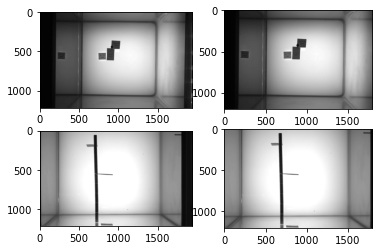

In [37]:
#CROP VERIFICATION ONLY ONCE!!!!!

box2 = (20.2346, 12.5507, 1820.0696, 1214.8702)
data1 = im.fromarray(data_raw1)
cropped_image1 = data1.crop(box2)

data2 = im.fromarray(data_raw2)
cropped_image2 = data2.crop(box2)


#Convert images to grayscale
figs, plots = plt.subplots(2,2)
plots[0,0].imshow(data_raw1, cmap='gray', vmin=0, vmax=255)
plots[1,0].imshow(data_raw2, cmap='gray', vmin=0, vmax=255)
plots[0,1].imshow(cropped_image1, cmap='gray', vmin=0, vmax=255)
plots[1,1].imshow(cropped_image2, cmap='gray', vmin=0, vmax=255)

In [184]:
#CROP VIDEO
cropped_vid1 = []
for i in range(len(video_array1)): 
    data_i1 = im.fromarray(video_array1[i])
    data1 = np.array(data_i1.crop(box2))
    cropped_vid1.append(data1)

In [185]:
cropped_vid2 = []
for i in range(len(video_array2)):
    data_i2 = im.fromarray(video_array2[i])
    data2 = np.array(data_i2.crop(box2))
    cropped_vid2.append(data2)

In [186]:
#JUST ONCE
#VIDEO PARAMETERS
frame_width_top = int(data1.shape[1])
frame_height_top = int(data1.shape[0])

frame_width_side = int(data2.shape[1])
frame_height_side = int(data2.shape[0])

In [187]:
frames = len(cropped_vid1)
print('total frames = ',frames)
name_video1 = 'VID_TOP-0.mp4'
name_video2 = 'VID_FRONT-0.mp4'

total frames =  3661


In [188]:
#Syntax: cv2.VideoWriter( filename, fourcc, fps, frameSize )
output_video1 = cv2.VideoWriter(name_video1, fourcc, (len(video_array1)/seconds), (frame_width_top, frame_height_top))

for i in range(len(cropped_vid1)):
    output_video1.write(cropped_vid1[i])
 
output_video1.release()

In [189]:
output_video2 = cv2.VideoWriter(name_video2, fourcc, (len(video_array2)/seconds), (frame_width_side, frame_height_side))
for i in range(len(cropped_vid2)):
    output_video2.write(cropped_vid2[i])
 
output_video2.release()

In [190]:
#stop communication from both cameras
cam1.stop_acquisition()
cam1.close_device()
cam2.stop_acquisition()
cam2.close_device()